In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import spacy
from torchtext.vocab import Vectors
from scipy.special import expit as sigmoid
from metrics import Single_deletion

import dianna
from dianna.utils.tokenizers import SpacyTokenizer
from dianna import visualization

In [13]:
model_path = Path().absolute().parent / 'models/movie_review_model.onnx'
word_vector_path = Path().absolute().parent / 'data/movie_reviews_word_vectors.txt'
labels = ("negative", "positive")

In [14]:
# ensure the tokenizer for english is available
spacy.cli.download('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


<h5> We load in the Movie Reviews model, keep in mind that tokenization has to appear during evaluation and therefore needs to be excluded during model inference. <h5>

In [15]:
class MovieReviewsModelRunner:
    def __init__(self, model, word_vectors, max_filter_size):
        self.run_model = dianna.utils.get_function(model)
        self.vocab = Vectors(word_vectors, cache=os.path.dirname(word_vectors))
        self.max_filter_size = max_filter_size
        
        self.tokenizer = SpacyTokenizer(name='en_core_web_sm')

    def __call__(self, sentences):
        output = []
        # ensure the input has a batch axis
        if isinstance(sentences, str):
            sentences = [sentences]

        for sentence in sentences:
            if isinstance(sentence, str):
                # tokenize and pad to minimum length
                tokens = self.tokenizer.tokenize(sentence)
                if len(tokens) < self.max_filter_size:
                    tokens += ['<pad>'] * (self.max_filter_size - len(tokens))
                
                # numericalize the tokens
                tokens_numerical = [self.vocab.stoi[token] if token in self.vocab.stoi else self.vocab.stoi['<unk>']
                                    for token in tokens]
            else: 
                tokens_numerical = sentence
            # run the model, applying a sigmoid because the model outputs logits, remove any remaining batch axis
            pred = float(sigmoid(self.run_model([tokens_numerical])))
            output.append(pred)

        # output two classes
        positivity = np.array(output)
        negativity = 1 - positivity
        return np.transpose([negativity, positivity])

In [16]:
# define model runner. max_filter_size is a property of the model
model_runner = MovieReviewsModelRunner(model_path, word_vector_path, max_filter_size=5)
review = "The movie started out great but the ending was dissapointing."
deleter = Single_deletion(model_runner, model_runner.tokenizer.tokenize, word_vector_path, max_filter_size=5)

TypeError: __init__() got an unexpected keyword argument 'max_filter_size'

In [ ]:
salience_map = dianna.explain_text(model_runner, review, model_runner.tokenizer, 'LIME',
                                                labels=[labels.index('positive')])[0]
words, indices, relevances = deleter.sort_salience_map(salience_map)

In [ ]:
visualization.highlight_text(salience_map, model_runner.tokenizer.tokenize(review))

<h5> We visualize our evaluation from the deleter below alongside with correlations and error metrics. <h5>

In [ ]:
scores, init_score = deleter.evaluate(salience_map, review)

probability_drops = scores - init_score
deleter.visualize(salience_map, probability_drops)

(array([0.56364414, 0.54173788, 0.38823664, 0.86404698, 0.50315052,
        0.52204627, 0.33302391, 0.34937429, 0.53136855, 0.5238547 ]),
 0.5313685536384583)

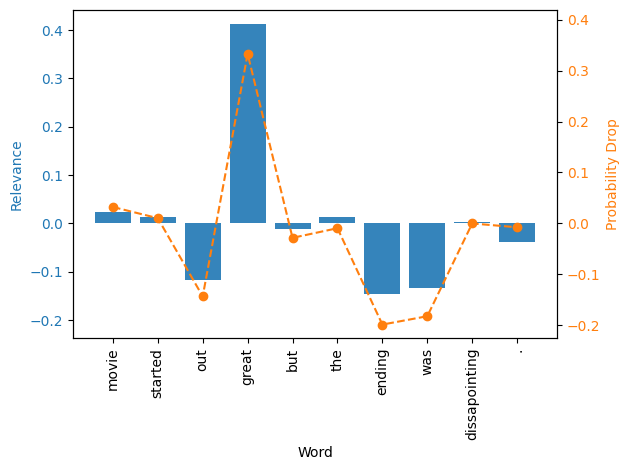

In [ ]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error as MAE

corr = spearmanr(relevances, probability_drops)
err = MAE(probability_drops, relevances)
print("Correlation Coefficient: {:.3f}, Signifcance: {:.10f}".format(*corr))
print("Mean Absolute Error: {:.3f}".format(err))

Correlation Coefficient: 0.903, Signifcance: 0.0003436122
Mean Absolute Error: 0.029


<h4> Conclusions <h4>
<h5> We conclude that both RISE and LIME exhibit good correlation and therefore good correctness of relevances. However, we also observe that RISE operates on a differnt scale, unrepresentative of the probability drops per feature. As such, intelligibility might be impeded. <h5>